In [2]:
import warnings
warnings.filterwarnings("ignore")
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(0) 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.utils.data_utils import get_file
from keras.models import model_from_json
%matplotlib inline

In [3]:
path = r'E:/RGU_PhD/SINCONF/IoT Network Intrusion Dataset.csv'
df = pd.read_csv(path)

In [4]:
df_new = df.sample(n=1000)
df_new.head(2)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
160486,192.168.0.13-192.168.0.15-0-0-0,192.168.0.15,0,192.168.0.13,0,0,31/05/2019 03:16:35 AM,145,2,1,...,0.0,0.0,0.0,72.5,0.707107,73.0,72.0,Anomaly,MITM ARP Spoofing,MITM ARP Spoofing
72324,192.168.0.24-27.102.104.90-45410-443-6,192.168.0.24,45410,27.102.104.90,443,6,04/09/2019 03:54:53 AM,75,0,2,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Hostbruteforceg


In [5]:
q=df_new['Label']

In [6]:
df_new = df_new.drop(['Cat','Sub_Cat','Label'],axis=1)
df_new.head(2)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
160486,192.168.0.13-192.168.0.15-0-0-0,192.168.0.15,0,192.168.0.13,0,0,31/05/2019 03:16:35 AM,145,2,1,...,0,0,0.0,0.0,0.0,0.0,72.5,0.707107,73.0,72.0
72324,192.168.0.24-27.102.104.90-45410-443-6,192.168.0.24,45410,27.102.104.90,443,6,04/09/2019 03:54:53 AM,75,0,2,...,0,0,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0


In [7]:
cat_feature = df_new.select_dtypes(include=['category', object]).columns
cat_feature

Index(['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp'], dtype='object')

In [8]:
from sklearn.preprocessing import LabelEncoder
df_new[cat_feature] = df_new[cat_feature].apply(LabelEncoder().fit_transform)
df_new.head(3)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
160486,42,57,0,29,0,0,656,145,2,1,...,0,0,0.0,0.0,0.0,0.0,72.5,0.707107,73.0,72.0
72324,374,61,45410,53,443,6,42,75,0,2,...,0,0,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0
272199,64,58,52930,29,9020,6,49,120,0,2,...,0,0,0.0,0.0,0.0,0.0,120.0,0.000000,120.0,120.0


In [9]:
df_new = df_new.replace([np.inf, -np.inf], np.nan).dropna()
df_new.head(3)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
160486,42,57,0,29,0,0,656,145,2,1,...,0,0,0.0,0.0,0.0,0.0,72.5,0.707107,73.0,72.0
72324,374,61,45410,53,443,6,42,75,0,2,...,0,0,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0
272199,64,58,52930,29,9020,6,49,120,0,2,...,0,0,0.0,0.0,0.0,0.0,120.0,0.000000,120.0,120.0


In [10]:
df_corr = df_new.corr()

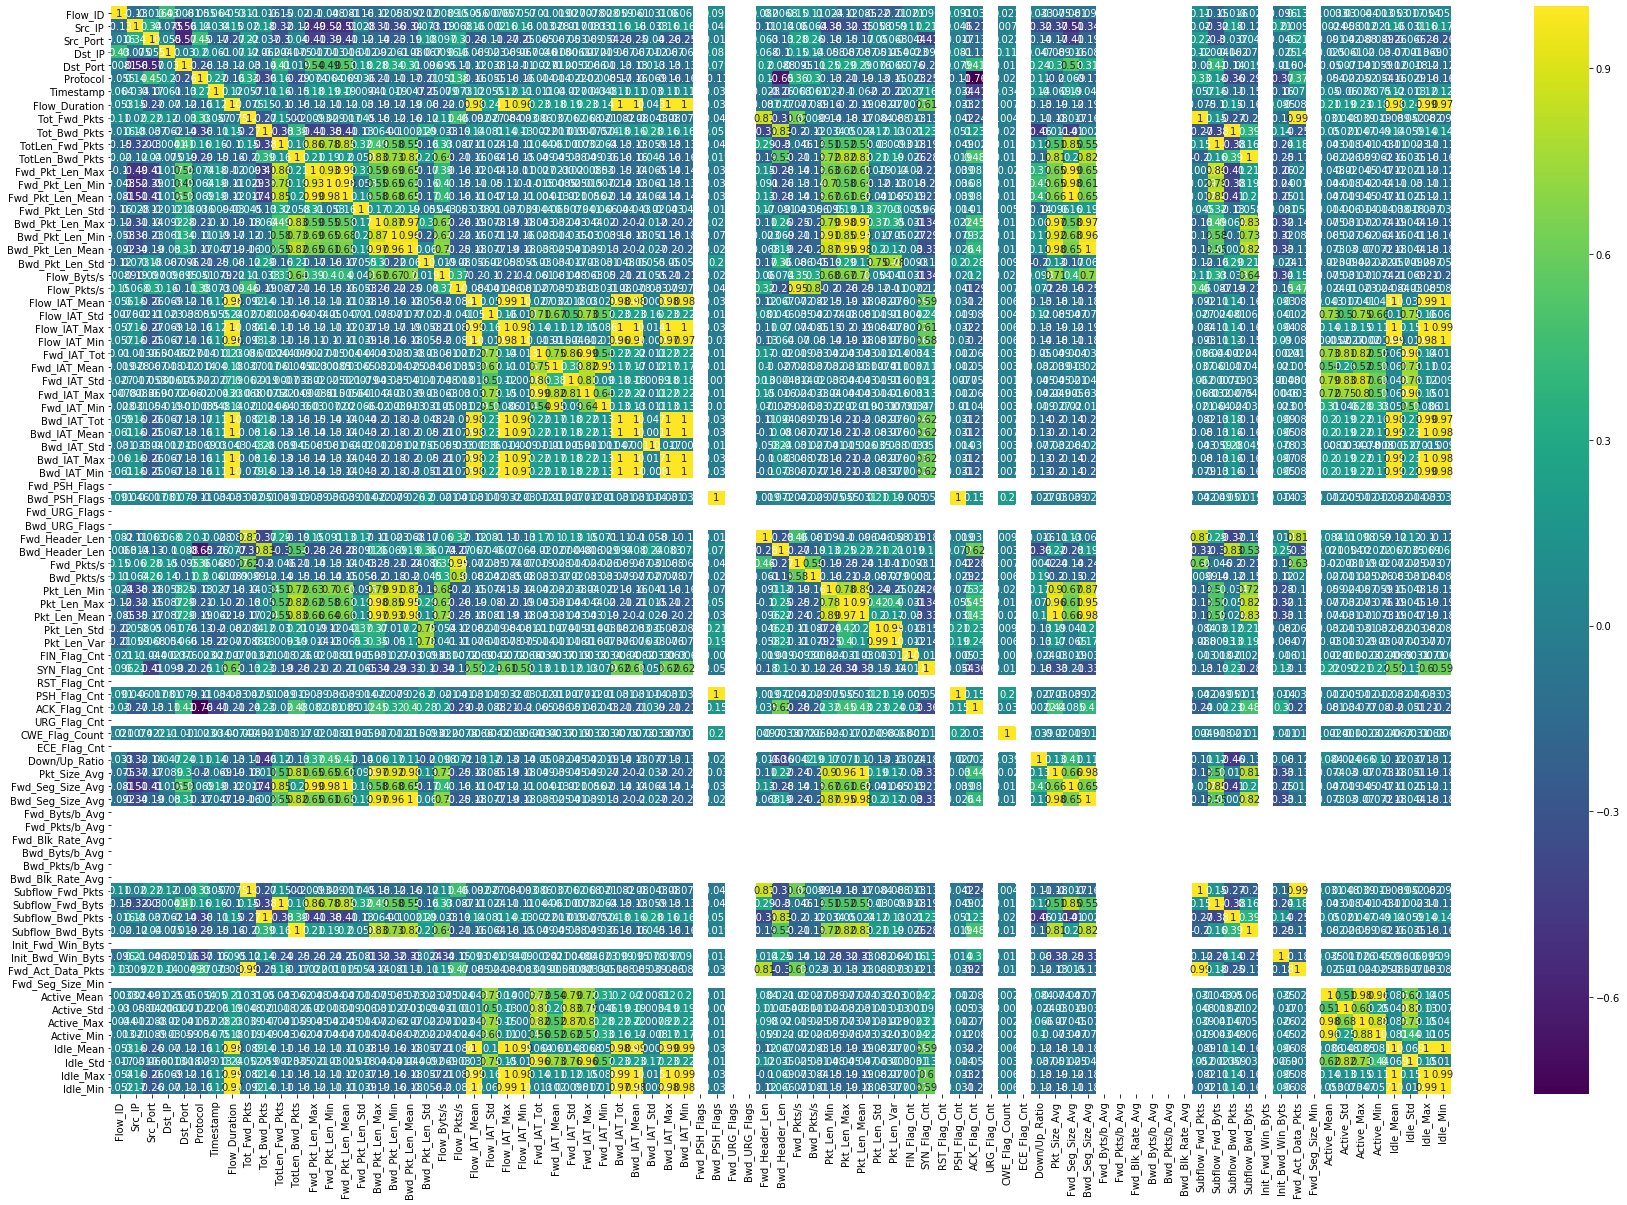

In [11]:
import seaborn as sns
plt.figure(figsize=(30,20))
sns.heatmap(df_corr, annot=True, cmap=plt.cm.viridis)
plt.savefig('corr_mat.png')
plt.show()

In [12]:
high_corr_var=np.where(df_corr>0.95)
# high_corr_var

In [13]:
high_corr_var=[(df_corr.columns[x],df_corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [14]:
high_corr_var

[('Flow_Duration', 'Flow_IAT_Mean'),
 ('Flow_Duration', 'Flow_IAT_Max'),
 ('Flow_Duration', 'Flow_IAT_Min'),
 ('Flow_Duration', 'Bwd_IAT_Tot'),
 ('Flow_Duration', 'Bwd_IAT_Mean'),
 ('Flow_Duration', 'Bwd_IAT_Max'),
 ('Flow_Duration', 'Bwd_IAT_Min'),
 ('Flow_Duration', 'Idle_Mean'),
 ('Flow_Duration', 'Idle_Max'),
 ('Flow_Duration', 'Idle_Min'),
 ('Tot_Fwd_Pkts', 'Subflow_Fwd_Pkts'),
 ('Tot_Fwd_Pkts', 'Fwd_Act_Data_Pkts'),
 ('Tot_Bwd_Pkts', 'Subflow_Bwd_Pkts'),
 ('TotLen_Fwd_Pkts', 'Subflow_Fwd_Byts'),
 ('TotLen_Bwd_Pkts', 'Subflow_Bwd_Byts'),
 ('Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Mean'),
 ('Fwd_Pkt_Len_Max', 'Fwd_Seg_Size_Avg'),
 ('Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean'),
 ('Fwd_Pkt_Len_Min', 'Fwd_Seg_Size_Avg'),
 ('Fwd_Pkt_Len_Mean', 'Fwd_Seg_Size_Avg'),
 ('Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Mean'),
 ('Bwd_Pkt_Len_Max', 'Pkt_Len_Max'),
 ('Bwd_Pkt_Len_Max', 'Pkt_Len_Mean'),
 ('Bwd_Pkt_Len_Max', 'Pkt_Size_Avg'),
 ('Bwd_Pkt_Len_Max', 'Bwd_Seg_Size_Avg'),
 ('Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean'),
 

In [15]:
df_new = df_new.drop(['Flow_Duration', 'Fwd_IAT_Std', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'Fwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Mean', 'Pkt_Size_Avg', 'Fwd_IAT_Tot', 'Fwd_IAT_Std', 'Fwd_IAT_Std', 'Bwd_IAT_Tot', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_PSH_Flags', 'Bwd_Header_Len', 'Pkt_Len_Std', 'Pkt_Size_Avg', 'Subflow_Fwd_Pkts', 'Active_Std', 'Idle_Mean' ],axis=1)

In [16]:
df_new.head(2)

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Max,Active_Min,Idle_Std,Idle_Max,Idle_Min
160486,42,57,0,29,0,0,656,0.0,0.0,0.0,...,-1,-1,0,0,0.0,0.0,0.0,0.707107,73.0,72.0
72324,374,61,45410,53,443,6,42,2896.0,0.0,0.0,...,-1,82,0,0,0.0,0.0,0.0,0.000000,75.0,75.0


In [17]:
from sklearn.preprocessing import StandardScaler
x=df_new.values
x = StandardScaler().fit_transform(x)

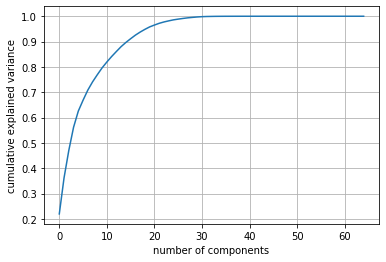

In [18]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA().fit(x)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('PCA_IoTID20')

In [38]:
# pca = PCA(n_components=30)
# principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5', 'principal component 6','principal component 7', 'principal component 8','principal component 9', 'principal component 10','principal component 11', 'principal component 12','principal component 13', 'principal component 14','principal component 15', 'principal component 16','principal component 17', 'principal component 18','principal component 19', 'principal component 20','principal component 21', 'principal component 22','principal component 23', 'principal component 24','principal component 25','principal component 26','principal component 27', 'principal component 28','principal component 29','principal component 30'])

In [75]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5', 'principal component 6','principal component 7', 'principal component 8','principal component 9', 'principal component 10','principal component 11', 'principal component 12','principal component 13', 'principal component 14','principal component 15', 'principal component 16','principal component 17', 'principal component 18','principal component 19', 'principal component 20'])

In [76]:
principalDf.head(3)

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20
0,4.435090,0.033140,-2.122145,2.872699,-0.644944,2.284947,0.302028,0.358478,-0.229550,-0.166120,0.153720,0.103772,-0.457813,-0.906070,0.947975,-1.889446,-0.832586,-0.161390,-0.738256,0.185971
1,2.407254,-2.182772,2.418241,-1.712796,0.136863,1.086873,-0.749576,-0.114691,1.006160,0.896965,0.912848,-0.352479,-0.330413,-0.514577,-0.786112,0.545845,0.024298,-0.158510,-0.402326,-0.237719
2,2.403773,-2.119523,2.350230,-1.325991,0.197905,0.948694,-0.201016,-0.256434,0.370167,-0.689049,0.101753,-0.234058,0.301623,0.020717,-0.111235,0.182022,-0.860172,0.071548,-0.412915,-0.668080


In [77]:
y=principalDf.values

In [152]:
from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=2,max_eps=np.inf,metric='chebyshev',cluster_method='xi').fit(y)

In [153]:
labels=clustering.labels_


In [154]:
# labels

In [155]:
no_clusters = len(np.unique(labels))
no_clusters

295

In [156]:
homogeneity_score(q, labels)

0.7737633000138928

In [157]:
no_noise = np.sum(np.array(labels) == -1, axis=0)
no_noise

173

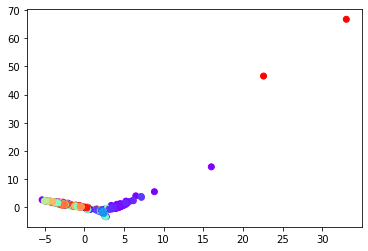

In [158]:
plt.scatter(y[:,0],y[:,1], c = labels, cmap='rainbow')#c = labels

In [226]:
index_cluster_0=np.where(labels==0)[0]
index_cluster_0

array([  0, 106, 128, 248, 261, 408, 434], dtype=int64)

In [227]:
index_cluster_1=np.where(labels==1)[0]
index_cluster_1

array([ 12, 162, 267, 413, 582, 623, 709], dtype=int64)

In [228]:
index_cluster_2=np.where(labels==2)[0]
index_cluster_2

array([ 80, 310, 410, 497, 563, 785], dtype=int64)

In [229]:
index_cluster_3=np.where(labels==3)[0]
index_cluster_3

array([118, 180, 186, 198, 479, 635, 667, 692], dtype=int64)

In [230]:
index_cluster_4=np.where(labels==4)[0]
index_cluster_4

array([ 47,  87, 195, 206, 219, 260, 378, 384, 522, 610, 629, 680, 700,
       710, 786, 792], dtype=int64)

In [83]:
from sklearn.metrics import homogeneity_score


In [121]:
homogeneity_score(q, labels)


0.7737633000138928

In [111]:
q.shape

(1000,)

In [112]:
labels.shape

(1000,)

In [105]:
from sklearn.metrics import homogeneity_score

homogeneity_score(q,labels)


0.755441249939369